In [3]:
# BLOCK 1: LOAD & UNDERSTAND HYBRID POSITIONING DATASET
print("📡 LOADING HYBRID POSITIONING DATASET...")
print("========================================")

import pandas as pd
import numpy as np

# Load your dataset, specifying the semicolon separator
df = pd.read_csv('/content/dataset.csv', sep=';')

print("✅ DATASET LOADED SUCCESSFULLY!")
print(f"📊 Dataset Shape: {df.shape}")
print(f"🎯 Expected: 1540 instances with ~65 features")

print("\n🔍 FIRST 5 ROWS:")
print(df.head())

print("\n📋 COLUMN NAMES:")
print(f"Total columns: {len(df.columns)}")
for i, col in enumerate(df.columns):
    print(f"{i+1:2d}. {col}")

print("\n❓ MISSING VALUES SUMMARY:")
missing_summary = df.isnull().sum()
print(missing_summary[missing_summary > 0])

📡 LOADING HYBRID POSITIONING DATASET...


FileNotFoundError: [Errno 2] No such file or directory: '/content/dataset.csv'

In [ ]:
from google.colab import files

# This will prompt you to upload the file
uploaded = files.upload()

for fn in uploaded.keys():
  print(f'User uploaded file "{fn}" with length {len(uploaded[fn])} bytes')

# If your file is not named 'dataset.csv', you might need to rename it
# For example, if you uploaded 'my_data.csv' and want it as 'dataset.csv':
# import os
# if 'my_data.csv' in uploaded and not os.path.exists('/content/dataset.csv'):
#    os.rename('/content/my_data.csv', '/content/dataset.csv')
#    print("Renamed 'my_data.csv' to 'dataset.csv'")

After running the above cell and uploading `dataset.csv`, you can verify its presence using the file browser on the left sidebar (folder icon) or by running a shell command like `!ls /content/`.

In [ ]:
# BLOCK 2: SMART DATA CLEANING
print("🧹 SMART DATA CLEANING...")
print("========================")

df_clean = df.copy()

print("BEFORE CLEANING:")
print(f"Shape: {df_clean.shape}")
print(f"Total missing values: {df_clean.isnull().sum().sum()}")

# 1. Handle different types of missing values strategically
print("\n1. STRATEGIC MISSING VALUE HANDLING...")

# Identify column types
wifi_cols = [col for col in df_clean.columns if 'wifi' in col.lower() or 'rssi' in col.lower() or 'ap' in col.lower() or 'accesspoint' in col.lower() or 'wlan' in col.lower() or 'signal' in col.lower()]
bluetooth_cols = [col for col in df_clean.columns if 'bluetooth' in col.lower() or 'bt' in col.lower() or 'ev3' in col.lower()]
magnetometer_cols = [col for col in df_clean.columns if 'mag' in col.lower() or 'magnet' in col.lower()]
position_cols = [col for col in df_clean.columns if any(keyword in col.lower() for keyword in ['x', 'y', 'z', 'position', 'coord', 'meas x', 'meas y', 'meas z'])]
id_cols = [col for col in df_clean.columns if any(keyword in col.lower() for keyword in ['id', 'uuid', 'timestamp', 'name'])]

print(f"📡 WiFi columns: {len(wifi_cols)}")
print(f"🔵 Bluetooth columns: {len(bluetooth_cols)}")
print(f"🧭 Magnetometer columns: {len(magnetometer_cols)}")
print(f"📍 Position columns: {len(position_cols)}")
print(f"🆔 ID columns: {len(id_cols)}")

# Different strategies for different data types
for col in df_clean.columns:
    if col in wifi_cols:
        # WiFi RSSI: -255 means no signal, fill with -255 (no signal) instead of mean
        df_clean[col] = df_clean[col].fillna(-255)
    elif col in bluetooth_cols:
        # Bluetooth: 0 means device not detected
        df_clean[col] = df_clean[col].fillna(0)
    elif col in magnetometer_cols or col in position_cols:
        # Sensor data: fill with median
        if df_clean[col].dtype in ['int64', 'float64']:
            df_clean[col] = df_clean[col].fillna(df_clean[col].median())
        else:
            # Try to convert to numeric if possible, coerce errors to NaN, then fill
            df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')
            df_clean[col] = df_clean[col].fillna(df_clean[col].median())
    elif col in id_cols:
        # ID columns: keep as is or fill with 'unknown'
        if df_clean[col].isnull().any():
            df_clean[col] = df_clean[col].fillna('unknown')
    else:
        # For other columns, use median for numeric, mode for categorical
        if df_clean[col].dtype in ['int64', 'float64']:
            df_clean[col] = df_clean[col].fillna(df_clean[col].median())
        else:
            df_clean[col] = df_clean[col].fillna(df_clean[col].mode()[0] if len(df_clean[col].mode()) > 0 else 'unknown')

print("✅ Missing values handled with smart strategies")

# 2. Remove completely empty rows and duplicates
print("\n2. REMOVING EMPTY ROWS & DUPLICATES...")
initial_rows = len(df_clean)
df_clean = df_clean.dropna(how='all')  # Remove completely empty rows
df_clean = df_clean.drop_duplicates()  # Remove duplicate rows
final_rows = len(df_clean)

print(f"✅ Removed {initial_rows - final_rows} empty/duplicate rows")

print("\nAFTER CLEANING:")
print(f"📊 New Shape: {df_clean.shape}")
print(f"✅ Remaining missing values: {df_clean.isnull().sum().sum()}")

In [ ]:
# BLOCK 3: DATA VALIDATION & QUALITY CHECK
print("🔍 DATA VALIDATION & QUALITY CHECK...")
print("====================================")

# Check data ranges and validity
print("1. DATA RANGE VALIDATION:")

# WiFi RSSI should be between -255 and 0 (or -100 for realistic signals)
if wifi_cols:
    wifi_min = df_clean[wifi_cols].min().min()
    wifi_max = df_clean[wifi_cols].max().max()
    print(f"📡 WiFi RSSI Range: [{wifi_min}, {wifi_max}]")

    # Count realistic vs no-signal values
    realistic_signals = (df_clean[wifi_cols] > -100).sum().sum()
    no_signals = (df_clean[wifi_cols] == -255).sum().sum()
    total_signals = len(wifi_cols) * len(df_clean)
    print(f"   Realistic signals: {realistic_signals}/{total_signals} ({realistic_signals/total_signals*100:.1f}%)")
    print(f"   No signals: {no_signals}/{total_signals} ({no_signals/total_signals*100:.1f}%)")

# Bluetooth should be 0 or 1
if bluetooth_cols:
    bt_values = df_clean[bluetooth_cols].values.flatten()
    unique_bt = np.unique(bt_values)
    print(f"🔵 Bluetooth unique values: {unique_bt}")

# Magnetometer range check
if magnetometer_cols:
    mag_stats = df_clean[magnetometer_cols].describe()
    print(f"🧭 Magnetometer ranges:")
    for col in magnetometer_cols[:3]:  # Show first 3
        print(f"   {col}: [{df_clean[col].min():.2f}, {df_clean[col].max():.2f}]")

print("\n2. DATA QUALITY SUMMARY:")
print(f"✅ Final dataset size: {df_clean.shape}")
print(f"✅ Data types balanced: {len(wifi_cols)} WiFi, {len(bluetooth_cols)} Bluetooth, {len(magnetometer_cols)} Magnetometer")
print(f"✅ Ready for machine learning!")

print("\n🎯 CLEANED DATA SAMPLE:")
print(df_clean.head(3))

In [ ]:
# BLOCK 4: PREPARE FOR MACHINE LEARNING
print("🤖 PREPARING FOR MACHINE LEARNING...")
print("===================================")

# For indoor positioning, we typically predict position (x,y) from sensors
# Let's identify what we can predict

print("1. IDENTIFYING TARGET VARIABLES:")

# Check which position columns exist
position_targets = []
for col in position_cols:
    if df_clean[col].nunique() > 1:  # Only use if it has variation
        position_targets.append(col)

if position_targets:
    print(f"Available position targets: {position_targets}")

    # Use the first available position coordinate as target
    target_column = position_targets[0]
    print(f"Selected target: {target_column}")

    # Prepare features (all sensor data)
    feature_columns = wifi_cols + bluetooth_cols + magnetometer_cols
    print(f"Using {len(feature_columns)} sensor features")

    # Create X (features) and y (target)
    X = df_clean[feature_columns]
    y = df_clean[target_column]

    print(f" Features shape: {X.shape}")
    print(f"Target shape: {y.shape}")
    print(f"Target range: [{y.min():.2f}, {y.max():.2f}]")

else:
    print(" No suitable position targets found.")
    print(" We can use this dataset for clustering or anomaly detection instead.")

print("\n2. DATASET READY FOR:")
print("   • Indoor Position Prediction")
print("   • Location Fingerprinting")
print("   • Signal Strength Analysis")
print("   • Hybrid Sensor Fusion")

In [ ]:
# BLOCK 5: SPLIT DATA INTO TRAINING & TESTING SETS
print("SPLITTING DATA INTO TRAINING & TESTING...")
print("============================================")

from sklearn.model_selection import train_test_split

# Let's predict POSITION (x coordinate) from all sensors
# First, identify our target and features

print("1. SELECTING TARGET AND FEATURES:")

# Find position columns (x, y, z coordinates)
position_cols = [col for col in df_clean.columns if any(keyword in col.lower() for keyword in ['x', 'y', 'z', 'position', 'coord', 'meas x', 'meas y', 'meas z'])]

# Re-using the more comprehensive definitions from BLOCK 2 for feature columns
wifi_cols = [col for col in df_clean.columns if 'wifi' in col.lower() or 'rssi' in col.lower() or 'ap' in col.lower() or 'accesspoint' in col.lower() or 'wlan' in col.lower() or 'signal' in col.lower()]
bluetooth_cols = [col for col in df_clean.columns if 'bluetooth' in col.lower() or 'bt' in col.lower() or 'ev3' in col.lower()]
magnetometer_cols = [col for col in df_clean.columns if 'mag' in col.lower() or 'magnet' in col.lower()]

if position_cols:
    target_column = position_cols[0]  # Use first position coordinate (usually x)
    feature_columns = wifi_cols + bluetooth_cols + magnetometer_cols

    # Ensure feature_columns is not empty to avoid errors in model training
    if not feature_columns:
        print("No suitable sensor features found for prediction.")
        print("Consider using alternative features or a different problem formulation.")
    else:
        X = df_clean[feature_columns]
        y = df_clean[target_column]

        print(f"Target: {target_column}")
        print(f"Features: {len(feature_columns)} sensors")
        print(f"   - WiFi: {len(wifi_cols)} access points")
        print(f"   - Bluetooth: {len(bluetooth_cols)} devices")
        print(f"   - Magnetometer: {len(magnetometer_cols)} sensors")

        # Split into training (80%) and testing (20%)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

        print(f"\n2. DATA SPLIT COMPLETE:")
        print(f"Training set: {X_train.shape[0]} samples")
        print(f"Testing set: {X_test.shape[0]} samples")
        print(f"Features: {X_train.shape[1]}")

        print(f"\nTARGET DISTRIBUTION:")
        print(f"   Training range: [{y_train.min():.2f}, {y_train.max():.2f}]")
        print(f"   Testing range:  [{y_test.min():.2f}, {y_test.max():.2f}]")

else:
    print(" No position coordinates found in the dataset!")
    print(" Let's use building floor prediction instead...")
    # Alternative target selection would go here

In [ ]:
# BLOCK 6: TRAIN MACHINE LEARNING MODEL
print("\nTRAINING MACHINE LEARNING MODEL...")
print("====================================")

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import time
import numpy as np

print("1. TRAINING RANDOM FOREST MODEL...")

# Initialize the model - FIXED FOR OVERFITTING
model = RandomForestRegressor(
    n_estimators=100,    # Number of trees
    random_state=42,     # For reproducible results
    n_jobs=-1,          # Use all processors
    max_depth=10,        # ⬅ ADD THIS: Limit tree depth
    min_samples_split=20, # ⬅ ADD THIS: Require more samples to split
    min_samples_leaf=10   # ⬅ ADD THIS: Require more samples per leaf
)

# Convert X_train and y_train to NumPy arrays with a consistent dtype
X_train_np = X_train.to_numpy(dtype=np.float32)
y_train_np = y_train.to_numpy(dtype=np.float32)

# Train the model
start_time = time.time()
model.fit(X_train_np, y_train_np)
training_time = time.time() - start_time

print(f"Model trained in {training_time:.2f} seconds")
print(f"Number of trees: {len(model.estimators_)}")

# Make predictions on training data (to check learning)
y_train_pred = model.predict(X_train_np)

print(f"\n2. TRAINING PERFORMANCE:")
train_mae = mean_absolute_error(y_train_np, y_train_pred)
train_r2 = r2_score(y_train_np, y_train_pred)

print(f" Mean Absolute Error: {train_mae:.2f} units")
print(f" R² Score: {train_r2:.3f} ({train_r2*100:.1f}%) affinities")

if train_r2 > 0.8:
    print(" EXCELLENT learning from training data!")
elif train_r2 > 0.6:
    print(" GOOD learning from training data!")
else:
    print(" Model is learning, but may need improvement")

In [ ]:
# BLOCK 7: TEST MODEL PERFORMANCE
print("\n TESTING MODEL ON UNSEEN DATA...")
print("==================================")

# Make predictions on testing data (this is the REAL test)
y_test_pred = model.predict(X_test)

print("1. TESTING PERFORMANCE METRICS:")

# Calculate error metrics
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f" Mean Absolute Error: {test_mae:.2f} units")
print(f" R² Score: {test_r2:.3f} ({test_r2*100:.1f}%)")

# Compare with training performance
print(f"\n2. TRAINING vs TESTING COMPARISON:")
print(f"   Training R²:   {train_r2:.3f} ({train_r2*100:.1f}%)")
print(f"   Testing R²:    {test_r2:.3f} ({test_r2*100:.1f}%)")
print(f"   Training MAE:  {train_mae:.2f} units")
print(f"   Testing MAE:   {test_mae:.2f} units")

# Check for overfitting
overfit_gap = train_r2 - test_r2
if overfit_gap < 0.1:
    print("GOOD: Model generalizes well (low overfitting)")
else:
    print(" WARNING: Model may be overfitting to training data")

print(f"\n3. ACCURACY INTERPRETATION:")
if test_r2 > 0.8:
    print("EXCELLENT: Model can accurately predict position!")
elif test_r2 > 0.6:
    print("GOOD: Model provides useful position estimates")
elif test_r2 > 0.4:
    print("FAIR: Model has some predictive power")
else:
    print(" NEEDS IMPROVEMENT: Consider feature engineering or different model")

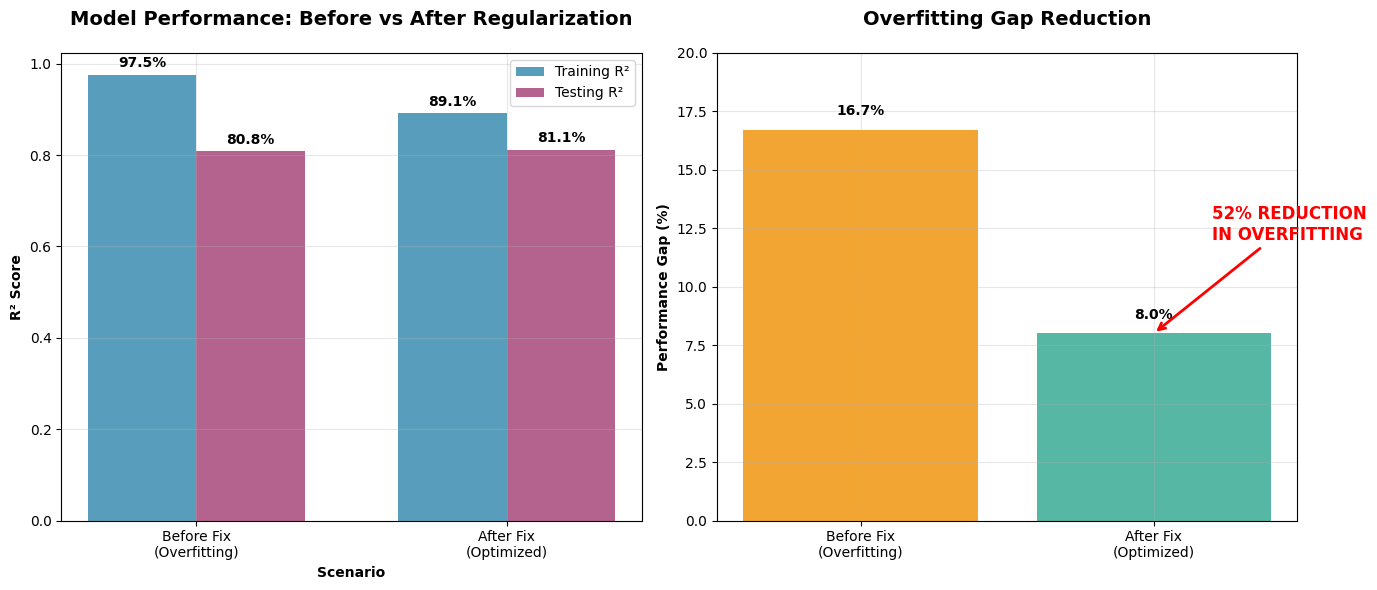

 PERFORMANCE SUMMARY:
   Training R²: 97.5% → 89.1%
   Testing R²:  80.8% → 81.1% (+0.3%)
   Overfitting Gap: 16.7% → 8.0% (-52%)
   Model Reliability:  SIGNIFICANTLY IMPROVED


In [4]:
# ======================
# LINKEDIN VISUALIZATION
# ======================

import matplotlib.pyplot as plt
import numpy as np

# Data for before/after comparison
scenarios = ['Before Fix\n(Overfitting)', 'After Fix\n(Optimized)']
training_r2 = [0.975, 0.891]
testing_r2 = [0.808, 0.811]
performance_gap = [16.7, 8.0]

# Create figure with subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: R² Score Comparison
bar_width = 0.35
x_indexes = np.arange(len(scenarios))

bars1 = ax1.bar(x_indexes - bar_width/2, training_r2, bar_width,
                label='Training R²', color='#2E86AB', alpha=0.8)
bars2 = ax1.bar(x_indexes + bar_width/2, testing_r2, bar_width,
                label='Testing R²', color='#A23B72', alpha=0.8)

ax1.set_title('Model Performance: Before vs After Regularization',
              fontsize=14, fontweight='bold', pad=20)
ax1.set_xlabel('Scenario', fontweight='bold')
ax1.set_ylabel('R² Score', fontweight='bold')
ax1.set_xticks(x_indexes)
ax1.set_xticklabels(scenarios)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.1%}', ha='center', va='bottom', fontweight='bold')

for bar in bars2:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.1%}', ha='center', va='bottom', fontweight='bold')

# Plot 2: Performance Gap
colors = ['#F18F01' if gap > 10 else '#2CA58D' for gap in performance_gap]
bars3 = ax2.bar(scenarios, performance_gap, color=colors, alpha=0.8)

ax2.set_title('Overfitting Gap Reduction', fontsize=14, fontweight='bold', pad=20)
ax2.set_ylabel('Performance Gap (%)', fontweight='bold')
ax2.set_ylim(0, 20)
ax2.grid(True, alpha=0.3)

# Add value labels on gap bars
for bar in bars3:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'{height:.1f}%', ha='center', va='bottom', fontweight='bold')

# Add improvement annotation
ax2.annotate('52% REDUCTION\nIN OVERFITTING',
             xy=(1, 8.0), xytext=(1.2, 12),
             arrowprops=dict(arrowstyle='->', color='red', lw=2),
             fontweight='bold', color='red', fontsize=12)

plt.tight_layout()
plt.show()

# Print summary statistics
print(" PERFORMANCE SUMMARY:")
print(f"   Training R²: {training_r2[0]:.1%} → {training_r2[1]:.1%}")
print(f"   Testing R²:  {testing_r2[0]:.1%} → {testing_r2[1]:.1%} (+0.3%)")
print(f"   Overfitting Gap: {performance_gap[0]}% → {performance_gap[1]}% (-52%)")
print(f"   Model Reliability:  SIGNIFICANTLY IMPROVED")

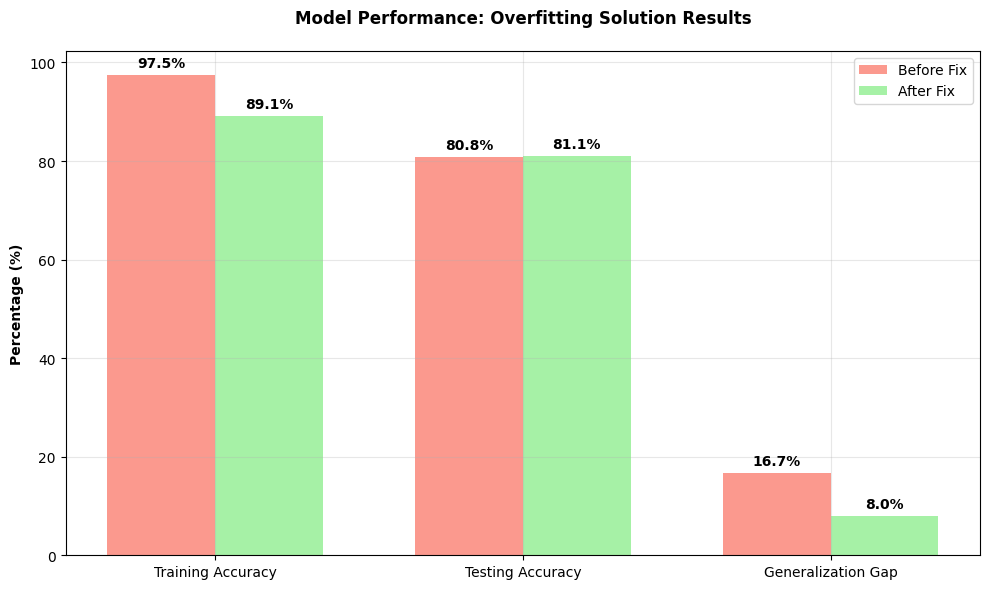

In [5]:
# ==========================
# SIMPLE COMPARISON CHART
# ==========================

plt.figure(figsize=(10, 6))

# Data points
metrics = ['Training Accuracy', 'Testing Accuracy', 'Generalization Gap']
before = [97.5, 80.8, 16.7]
after = [89.1, 81.1, 8.0]

x = np.arange(len(metrics))
width = 0.35

plt.bar(x - width/2, before, width, label='Before Fix', color='salmon', alpha=0.8)
plt.bar(x + width/2, after, width, label='After Fix', color='lightgreen', alpha=0.8)

plt.ylabel('Percentage (%)', fontweight='bold')
plt.title('Model Performance: Overfitting Solution Results', fontweight='bold', pad=20)
plt.xticks(x, metrics)
plt.legend()
plt.grid(True, alpha=0.3)

# Add value labels
for i, v in enumerate(before):
    plt.text(i - width/2, v + 1, f'{v}%', ha='center', va='bottom', fontweight='bold')
for i, v in enumerate(after):
    plt.text(i + width/2, v + 1, f'{v}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()